In [ ]:
from google.colab import files
files.upload()

In [2]:
!pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

ref                                                          title                                           size  lastUpdated          downloadCount  
-----------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  
alexgude/california-traffic-collision-data-from-switrs       California Traffic Collision Data from SWITRS    1GB  2020-11-22 16:51:55            550  
babyoda/women-entrepreneurship-and-labor-force               Women Entrepreneurship and Labor Force           1KB  2020-11-21 08:38:51           1693  
szymonjanowski/internet-articles-data-with-users-engagement  Internet news data with readers engagement       3MB  2020-11-21 17:09:57            727  
sakshigoyal7/credit-card-customers                           Credit Card customers                          379KB  2020-11-19 07:38:44           3152  
imoore/2020-us-general-election-turnout-rates                2020 US General Election Tu

In [3]:
!kaggle datasets download -d stackoverflow/stacksample

100% 1.10G/1.11G [00:18<00:00, 39.1MB/s]
100% 1.11G/1.11G [00:18<00:00, 64.3MB/s]


In [4]:
!unzip stacksample.zip

Archive:  stacksample.zip
  inflating: Answers.csv             
  inflating: Questions.csv           
  inflating: Tags.csv                


In [5]:
!pip install scikit-multilearn

     |████████████████████████████████| 92kB 4.3MB/s 


In [2]:
# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from datetime import datetime
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB


In [3]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
questions = pd.read_csv('Questions.csv',encoding="ISO-8859-1")
tags = pd.read_csv('Tags.csv', encoding="ISO-8859-1")

In [5]:
#Question Structure
idx = 8965
Id = questions.Id[idx]
title = questions.Title[idx]
body = questions.Body[idx]
score = questions.Score[idx]
print("ID :",Id)
print("Title :", title)
print("Body :", body)
curr_tags = tags[tags.Id == Id]['Tag']
tags_str = ", ".join(curr_tags.tolist())
print("Score :",score)
print("Tags :", tags_str)

ID : 584870
Title : Why âNo database selectedâ SQLException?
Body : <p>why this program is not executing when it goes in to the do while loop second time and why it is giving the exception "Exception java.sql.SQLException: [MySQL][ODBC 5.1 Driver][mysqld-5.0.51a-community-nt]No database selected"</p>

<pre><code>//import java.io.InputStream;
import java.sql.Connection;
import java.sql.DriverManager;
import java.sql.ResultSet;
import java.sql.SQLException;
import java.sql.Statement;
import java.util.Scanner;
import java.util.Vector;

public class DataBase {

    public void LoadDriver() {

        // Load the JDBC-ODBC bridge driver
        try {
            Class.forName("sun.jdbc.odbc.JdbcOdbcDriver");
        } catch (ClassNotFoundException ee) {
            ee.printStackTrace();
        }
    }

    // 2.open a data source name by means of the jdbcodbcdriver.

    static void connect() throws SQLException {

        // Connect to the database
        Connection con = DriverManag

In [6]:
tags.head(10)

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn
5,90,branch
6,90,branching-and-merging
7,120,sql
8,120,asp.net
9,120,sitemap


In [7]:
tags = tags.groupby('Id').agg(lambda x: x.tolist())

In [8]:
tags['Tag'] = tags['Tag'].str.join(" ")

In [9]:
tags.head()

,Tag
Id,
80,flex actionscript-3 air
90,svn tortoisesvn branch branching-and-merging
120,sql asp.net sitemap
180,algorithm language-agnostic colors color-space
260,c# .net scripting compiler-construction


In [10]:
questions.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [11]:
df = pd.merge(questions, tags, on='Id')

In [12]:
df.head(10)

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body,Tag
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction
5,330,63.0,2008-08-02T02:51:36Z,NaN,29,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,c++ oop class nested-class
6,470,71.0,2008-08-02T15:11:47Z,2016-03-26T05:23:29Z,13,Homegrown consumption of web services,<p>I've been writing a few web services for a ...,.net web-services
7,580,91.0,2008-08-02T23:30:59Z,NaN,21,Deploying SQL Server Databases from Test to Live,<p>I wonder how you guys manage deployment of ...,sql-server sql-server-2005 deployment release-...
8,650,143.0,2008-08-03T11:12:52Z,NaN,79,Automatically update version number,<p>I would like the version property of my app...,c# visual-studio versioning
9,810,233.0,2008-08-03T20:35:01Z,NaN,9,Visual Studio Setup Project - Per User Registr...,<p>I'm trying to maintain a Setup Project in <...,windows visual-studio registry installation


In [13]:
def removeHtmlTags(data):
    cleaner = re.compile('<.*?>')
    clean_text = re.sub(cleaner," ",str(data))
    return clean_text
sent = "<html><p>hello world</p></html>"
rece = removeHtmlTags(sent)
print(rece)

  hello world  


In [14]:
preprossed_data = []
questions_proccesed = 0
data_size = 50000

In [15]:
start = datetime.now()
questions_with_code=0
for i in range(min(data_size, len(questions))):
    is_code = 0

    title = df['Title'][i]
    question = df['Body'][i]
    tag = df['Tag'][i]
    
    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)

    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))

    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=removeHtmlTags(question.encode('utf-8'))

    title=title.encode('utf-8')

    question=str(title)+" "+str(question)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    tup = (question,code,is_code,tag)
    preprossed_data.append(tup)
    questions_proccesed += 1
    if (questions_proccesed%10000==0):
        print("number of questions completed=",questions_proccesed)
    
print("Time take to execute this cell ", datetime.now()-start)

number of questions completed= 10000
number of questions completed= 20000
number of questions completed= 30000
number of questions completed= 40000
number of questions completed= 50000
Time take to execute this cell  0:01:08.841446


In [16]:
preprossed_data[25]

('travers collect classic asp want abl thing thing nend classic asp net',
 '[]',
 0,
 'asp-classic vbscript')

In [17]:
data = pd.DataFrame(preprossed_data[:data_size], columns =['question', 'code', 'is_code','tag'])
data.drop(['is_code','code'], axis =1, inplace=True)

In [18]:
data.head()

,question,tag
0,sqlstatement execut multipl queri one statemen...,flex actionscript-3 air
1,good branch merg tutori tortoisesvn realli goo...,svn tortoisesvn branch branching-and-merging
2,asp net site map anyon got experi creat sql ba...,sql asp.net sitemap
3,function creat color wheel someth pseudo solv ...,algorithm language-agnostic colors color-space
4,ad script function net applic littl game writt...,c# .net scripting compiler-construction


In [19]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
Y = vectorizer.fit_transform(data['tag'].values.astype('U'))

In [20]:
print(vectorizer.get_feature_names())

['.app', '.bash-profile', '.doc', '.emf', '.htaccess', '.net', '.net-1.0', '.net-1.1', '.net-2.0', '.net-3.0', '.net-3.5', '.net-4.0', '.net-4.0-beta-2', '.net-assembly', '.net-attributes', '.net-client-profile', '.net-framework-source', '.net-micro-framework', '.net-remoting', '.netrc', '.nettiers', '.post', '.sbr', '.war', '16-bit', '2-satisfiability', '2-tier', '256color', '2d', '3-tier', '32-bit', '32bit-64bit', '3d', '3d-studio', '3dcamera', '3des', '3dsmax', '3gp', '64bit', '6502', '68000', '7bit', '7zip', '8-puzzle', '8051', '960.gs', 'a-star', 'aasm', 'ab-testing', 'abaddressbook', 'abap', 'abbr', 'abcpdf', 'abi', 'ablecommerce', 'abort', 'about-box', 'abpeoplepickerview', 'abpersonviewcontroller', 'absolute-path', 'absolute-value', 'absolutelayout', 'abstract', 'abstract-base-class', 'abstract-class', 'abstract-data-type', 'abstract-factory', 'abstract-function', 'abstract-syntax-tree', 'abstraction', 'abuse', 'acceleration', 'accelerator', 'acceleratorkey', 'accelerometer', '

In [21]:
def tags_to_choose(n):
    t = Y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=Y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_covered_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [22]:
questions_covered = []
total_tags=Y.shape[1]
total_qs=data.shape[0]
for i in range(50, total_tags, 50):
    questions_covered.append(np.round(((total_qs-questions_covered_fn(i))/total_qs)*100,3))

In [23]:
questions_covered[:10]

[78.016, 85.97, 88.86, 91.136, 92.446, 93.572, 94.404, 95.196, 95.676, 96.074]

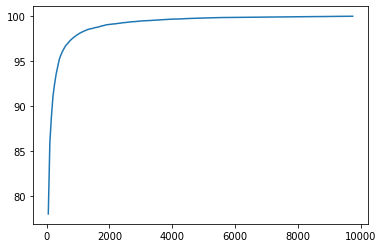

In [24]:
xlabel = [i for i in range(50,total_tags,50)]
plt.plot(xlabel,questions_covered)

In [25]:
multilabel_yx = tags_to_choose(200)
print("number of questions that are not covered :", questions_covered_fn(200),"out of ", total_qs)

number of questions that are not covered : 4432 out of  50000


In [26]:
print("Number of tags in sample :", Y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/Y.shape[1])*100,"%)")

Number of tags in sample : 9776
number of tags taken : 200 ( 2.0458265139116203 %)


In [27]:
total_size=data.shape[0]
train_size=int(0.80*total_size)

x_train=data.head(train_size)
x_test=data.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [28]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (40000, 200)
Number of data points in test data : (10000, 200)


In [29]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:32.043933


In [30]:
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))


accuracy : 0.2834
macro f1 score : 0.41525835519822735
micro f1 scoore : 0.5395811956067343
hamming loss : 0.0060575
Precision recall report :
               precision    recall  f1-score   support

           0       0.61      0.31      0.41      1116
           1       0.80      0.58      0.67       802
           2       0.54      0.17      0.26       540
           3       0.84      0.63      0.72       743
           4       0.80      0.49      0.61       484
           5       0.73      0.51      0.60       556
           6       0.69      0.34      0.46       449
           7       0.89      0.74      0.81       520
           8       0.87      0.60      0.71       406
           9       0.91      0.66      0.77       483
          10       0.57      0.39      0.46       287
          11       0.56      0.28      0.38       318
          12       0.58      0.42      0.49       186
          13       0.85      0.65      0.74       288
          14       0.83      0.68      0.75  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
classifier = OneVsRestClassifier(LogisticRegression(penalty='l2'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))

accuracy : 0.2092
macro f1 score : 0.18908139175141372
micro f1 scoore : 0.36396852164137156
hamming loss : 0.006789
Precision recall report :
               precision    recall  f1-score   support

           0       0.66      0.19      0.30      1116
           1       0.83      0.41      0.55       802
           2       0.66      0.09      0.16       540
           3       0.90      0.47      0.62       743
           4       0.82      0.34      0.48       484
           5       0.77      0.37      0.50       556
           6       0.74      0.19      0.30       449
           7       0.91      0.57      0.70       520
           8       0.89      0.36      0.51       406
           9       0.94      0.39      0.55       483
          10       0.65      0.28      0.39       287
          11       0.64      0.16      0.26       318
          12       0.56      0.28      0.38       186
          13       0.91      0.47      0.62       288
          14       0.89      0.53      0.66  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
# classifier = OneVsRestClassifier(svm.SVC(kernel='linear'))
# classifier.fit(x_train_multilabel, y_train)
# predictions = classifier.predict(x_test_multilabel)

# print("accuracy :",metrics.accuracy_score(y_test,predictions))
# print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
# print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
# print("hamming loss :",metrics.hamming_loss(y_test,predictions))
# print("Precision recall report :\n",metrics.classification_report(y_test, predictions))

In [33]:
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))


accuracy : 0.3139
macro f1 score : 0.4029361817742817
micro f1 scoore : 0.5695957487189219
hamming loss : 0.0056695
Precision recall report :
               precision    recall  f1-score   support

           0       0.58      0.34      0.43      1116
           1       0.79      0.61      0.69       802
           2       0.53      0.16      0.25       540
           3       0.84      0.67      0.74       743
           4       0.80      0.52      0.63       484
           5       0.76      0.55      0.64       556
           6       0.70      0.36      0.48       449
           7       0.88      0.82      0.85       520
           8       0.90      0.68      0.78       406
           9       0.91      0.75      0.82       483
          10       0.63      0.36      0.46       287
          11       0.59      0.28      0.38       318
          12       0.59      0.39      0.47       186
          13       0.86      0.69      0.77       288
          14       0.86      0.73      0.79   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
start = datetime.now()
questions_with_code=0
for i in range(min(data_size, len(questions))):
    is_code = 0

    title = df['Title'][i]
    question = df['Body'][i]
    tag = df['Tag'][i]
    
    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)

    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))

    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=removeHtmlTags(question.encode('utf-8'))

    title=title.encode('utf-8')

    question=str(title)+" "+ str(title)+" "+ str(title)+" "+str(title)+" "+str(title)+" "+str(question)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    tup = (question,code,is_code,tag)
    preprossed_data.append(tup)
    questions_proccesed += 1
    if (questions_proccesed%10000==0):
        print("number of questions completed=",questions_proccesed)
    
print("Time take to execute this cell ", datetime.now()-start)

number of questions completed= 60000
number of questions completed= 70000
number of questions completed= 80000
number of questions completed= 90000
number of questions completed= 100000
Time take to execute this cell  0:01:31.768460


In [35]:
data = pd.DataFrame(preprossed_data[:data_size], columns =['question', 'code', 'is_code','tag'])
data.drop(['is_code','code'], axis =1, inplace=True)

In [36]:
total_size=data.shape[0]
train_size=int(0.80*total_size)

x_train=data.head(train_size)
x_test=data.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [37]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:32.955623


In [38]:
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))

accuracy : 0.2849
macro f1 score : 0.41532606834244645
micro f1 scoore : 0.5409293298321727
hamming loss : 0.0060315
Precision recall report :
               precision    recall  f1-score   support

           0       0.62      0.32      0.42      1116
           1       0.80      0.57      0.66       802
           2       0.55      0.18      0.27       540
           3       0.84      0.63      0.72       743
           4       0.80      0.49      0.61       484
           5       0.73      0.51      0.60       556
           6       0.70      0.33      0.45       449
           7       0.89      0.75      0.81       520
           8       0.86      0.61      0.71       406
           9       0.91      0.66      0.77       483
          10       0.59      0.34      0.43       287
          11       0.55      0.27      0.36       318
          12       0.58      0.44      0.50       186
          13       0.85      0.67      0.75       288
          14       0.84      0.70      0.76  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))

accuracy : 0.3139
macro f1 score : 0.40421805482307976
micro f1 scoore : 0.5696914424684603
hamming loss : 0.005662
Precision recall report :
               precision    recall  f1-score   support

           0       0.59      0.34      0.43      1116
           1       0.79      0.61      0.69       802
           2       0.52      0.15      0.23       540
           3       0.83      0.68      0.75       743
           4       0.79      0.55      0.65       484
           5       0.76      0.55      0.64       556
           6       0.72      0.34      0.46       449
           7       0.89      0.81      0.85       520
           8       0.89      0.68      0.77       406
           9       0.91      0.76      0.82       483
          10       0.58      0.32      0.41       287
          11       0.60      0.25      0.35       318
          12       0.61      0.44      0.51       186
          13       0.87      0.70      0.78       288
          14       0.86      0.73      0.79   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
# classifier = OneVsRestClassifier(svm.SVC(kernel='linear'))
# classifier.fit(x_train_multilabel, y_train)
# predictions = classifier.predict(x_test_multilabel)

# print("accuracy :",metrics.accuracy_score(y_test,predictions))
# print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
# print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
# print("hamming loss :",metrics.hamming_loss(y_test,predictions))
# print("Precision recall report :\n",metrics.classification_report(y_test, predictions))